In [1]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird

Some aesthetic definitions for the plots

In [2]:
font = {'size': 16, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Instantiate a Class object, set parameters and compute

In [3]:
zpk = 0.5

M = Class()
M.set({'ln10^{10}A_s': 3.044,
       'n_s': 0.9649,
       'h': 0.6736,
       'omega_b': 0.02237,
       'omega_cdm': 0.120,
      })

M.set({'output': 'mPk',
       'P_k_max_1/Mpc': 1.0,
       'z_max_pk': zpk})

M.compute()

Get the linear power spectrum at redshift zpk, and plot it

In [4]:
# k in h/Mpc
kk = np.logspace(-5, 0, 200)

# P(k) in (Mpc/h)**3
Pk = [M.pk(ki*M.h(), zpk)*M.h()**3 for ki in kk]

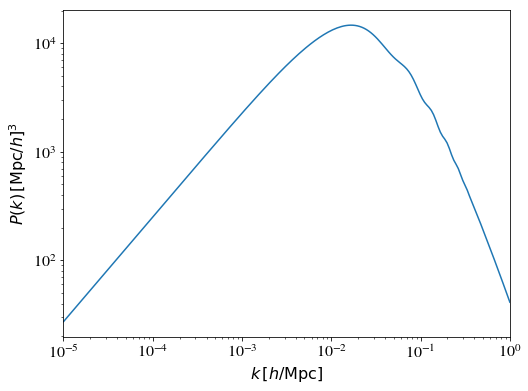

In [5]:
plt.figure()

plt.plot(kk, Pk, 'C0-')

plt.xscale('log')
plt.yscale('log')

plt.xlim(kk[0], kk[-1])

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

Define a vector with the bias parameters bs = [b1, b2, b3, b4, cct, cr1, cr2]

In [6]:
bs = [2., 1., 0.5, 0., 0.5, 2., 0]

Define an object of the class Common, with settings for the pybird objects

In [7]:
common = pybird.Common(optiresum=True)

Instantiate the class that calculates the nonlinear power spectrum.
It will load precomputed FFTLog matrices if they are in the folder, otherwise it will compute new ones.

In [8]:
import time

In [9]:
time1 = time.time()
nonlinear = pybird.NonLinear(load=True, save=True, co=common)
print(time.time() - time1)

0.6514439582824707


Instantiate the class that calculates the resummed power spectrum

In [10]:
resum = pybird.Resum(co=common)

Finally, instantiate the class that applies the Alcock-Paczynski (AP) effect, the window function, and the fiber collisions

In [11]:
kdata = np.linspace(0.005, 0.3, 50)
Om_AP = 0.31
z_AP = zpk

In [12]:
projection = pybird.Projection(kdata, Om_AP, z_AP, co=common)

Now instantiate the main class

In [13]:
DA = M.angular_distance(zpk) * M.Hubble(0.)
H = M.Hubble(zpk) / M.Hubble(0.)
f = M.scale_independent_growth_factor_f(zpk)

bird = pybird.Bird(kk, Pk, f, DA, H, zpk, which='full', co=common)

Call the routine to get the power spectrum (and correlation function), and compute it in the bird object. The correlation function is useful for the IR-resummation.

In [14]:
time1 = time.time()
nonlinear.PsCf(bird)
bird.setPsCf(bs)
print(time.time()-time1)

bird.setfullPs()
noresumPs = np.copy(bird.fullPs)

0.24565696716308594


Compute the resummed power spectrum

In [15]:
time1 = time.time()
resum.Ps(bird)
print(time.time() - time1)

resumPs = np.copy(bird.fullPs)

0.17731881141662598


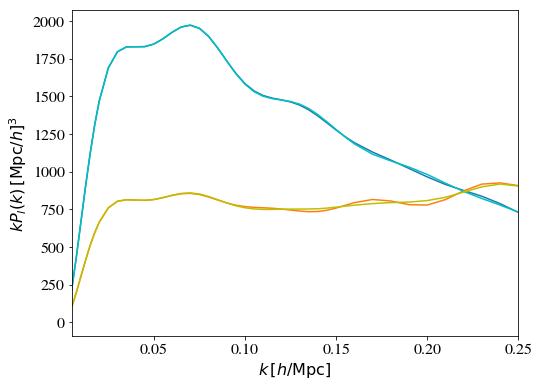

In [16]:
plt.figure()

plt.plot(common.k, common.k * noresumPs[0], 'C0-', label = 'mono resum')
plt.plot(common.k, common.k * noresumPs[1], 'C1-', label = 'quad resum')

plt.plot(common.k, common.k * resumPs[0], 'c-', label = 'mono resum')
plt.plot(common.k, common.k * resumPs[1], 'y-', label = 'quad resum')

plt.xlim(0.005, 0.25)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

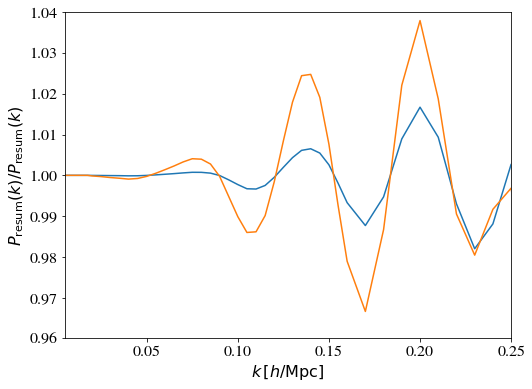

In [17]:
plt.figure()

plt.plot(common.k, resumPs[0]/noresumPs[0], 'C0-', label = 'mono')
plt.plot(common.k, resumPs[1]/noresumPs[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.ylim(0.96, 1.04)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm resum}(k)/P_{\rm resum}(k)$')

plt.show()

Finally, set the AP effect and/or the window function and interpolate on the k-array of the data

In [18]:
projection.AP(bird)
projection.kdata(bird)

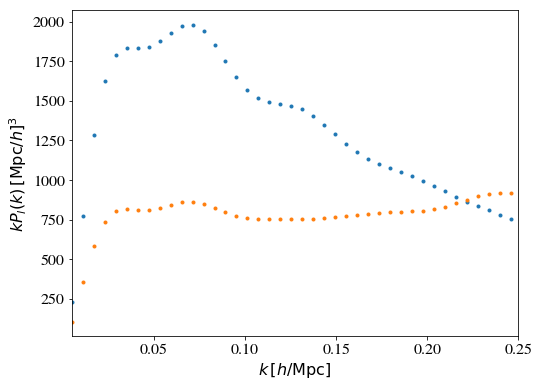

In [19]:
plt.figure()

plt.plot(kdata, kdata * bird.fullPs[0], 'C0.', label = 'mono')
plt.plot(kdata, kdata * bird.fullPs[1], 'C1.', label = 'quad')

plt.xlim(0.005, 0.25)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

The power spectrum can also be computed without specifying the EFT parameters. This is interesting for subsampling them or to marginalize over the ones that appear only linearly in the power spectrum.

In [115]:
time1 = time.time()
raven = pybird.Bird(kk, Pk, f, DA, H, zpk, which='all', co=common)
nonlinear.PsCf(raven)
raven.setPsCfl()
resum.Ps(raven)
projection.AP(raven)
projection.kdata(raven)
print(time.time() - time1)

0.952570915222168


The terms are given as follow:

In [21]:
b1, b2, b3, b4, b5, b6, b7 = bs
f = raven.f
b11 = np.array([ b1**2, 2.*b1*f, f**2 ])
bct = np.array([ 2.*b1*b5, 2.*b1*b6, 2.*b1*b7, 2.*f*b5, 2.*f*b6, 2.*f*b7 ])
bloop = np.array([ 1., b1, b2, b3, b4, b1*b1, b1*b2, b1*b3, b1*b4, b2*b2, b2*b4, b4*b4 ])
lin = np.einsum('b,lbx->lx', b11, raven.P11l)
loop = np.einsum('b,lbx->lx', bloop, raven.Ploopl) 
counterterm = np.einsum('b,lbx->lx', bct, raven.Pctl)
ravenPs = lin + loop + counterterm

The above is equivalent to the building function:

In [22]:
raven.setreducePslb(bs)

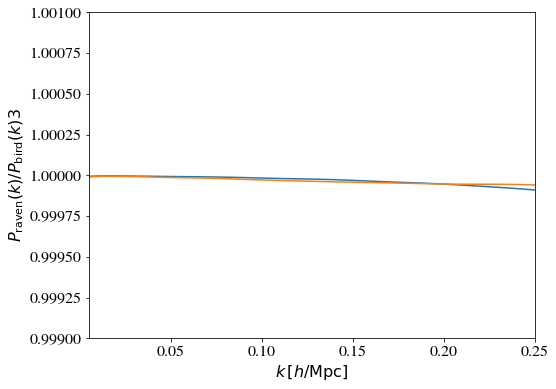

In [23]:
plt.figure()

plt.plot(kdata, raven.fullPs[0]/bird.fullPs[0], 'C0', label = 'mono')
plt.plot(kdata, raven.fullPs[1]/bird.fullPs[1], 'C1', label = 'quad')

plt.xlim(0.005, 0.25)
plt.ylim(1-.001, 1+.001)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$ P_{\rm raven}(k) / P_{\rm bird}(k)3$')

plt.show()

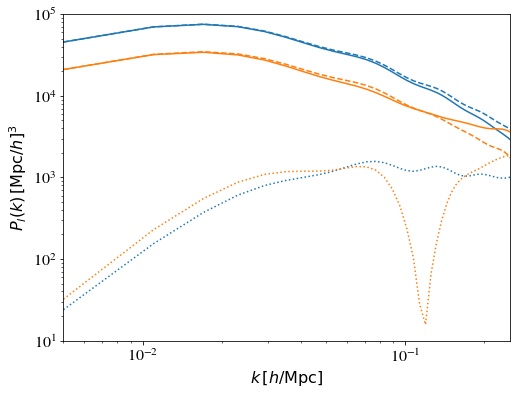

In [24]:
plt.figure()

plt.loglog(kdata, ravenPs[0], 'C0', label = 'mono')
plt.loglog(kdata, ravenPs[1], 'C1', label = 'quad')

plt.loglog(kdata, lin[0], 'C0--', label = 'mono lin')
plt.loglog(kdata, lin[1], 'C1--', label = 'quad lin')

plt.loglog(kdata, np.abs(loop[0]+counterterm[0]), 'C0:', label = 'mono loop')
plt.loglog(kdata, np.abs(loop[1]+counterterm[1]), 'C1:', label = 'quad loop')

plt.xlim(0.005, 0.25)
plt.ylim(10, 1e5)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

Let us apply the window function now as convolution in Fourier space. First we redefine the projection class to include the mask. It will load precomputed Fourier convolution mask if it is in the folder, otherwise it will compute a new one from a provided mask in configuration space.

In [121]:
from importlib import reload
reload(pybird)
projection = pybird.Projection(kdata, Om_AP, z_AP, 
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', path_to_window='./montepython_tree/data/pybird/Window', window_configspace_file='./montepython_tree/data/pybird/window_BOSS_CMASS_NGC_z057.dat')

Loaded mask: ./montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057.npy


Here is a masked bird

In [97]:
plover = pybird.Bird(kk, Pk, f, DA, H, zpk, which='full', co=common)
nonlinear.PsCf(plover)
plover.setPsCf(bs)
resum.Ps(plover)
projection.AP(plover)
projection.Window(plover)
projection.kdata(plover)

(0.005, 0.25)

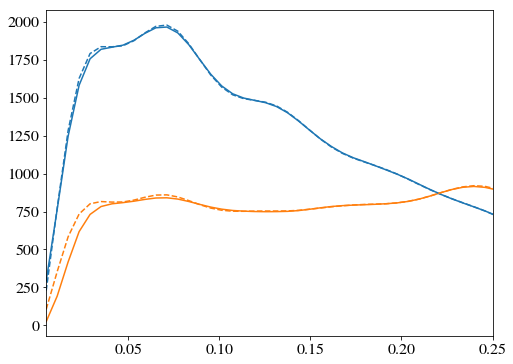

In [98]:
plt.plot(kdata, kdata*plover.fullPs[0], 'C0-')
plt.plot(kdata, kdata*plover.fullPs[1], 'C1-')
plt.plot(kdata, kdata*bird.fullPs[0], 'C0--')
plt.plot(kdata, kdata*bird.fullPs[1], 'C1--')
plt.xlim(0.005, 0.25)

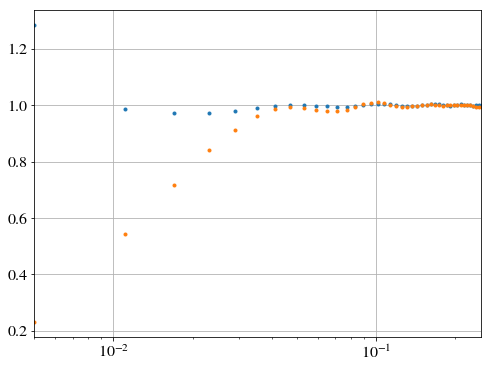

In [120]:
plt.plot(kdata, plover.fullPs[0]/bird.fullPs[0], 'C0.')
plt.plot(kdata, plover.fullPs[1]/bird.fullPs[1], 'C1.')
plt.grid()
plt.xlim(0.005, 0.25)
plt.xscale('log')